In [1]:
import webbpsf
import dLux as dl
import dLuxWebbpsf as dlW

import jax.numpy as np
import jax.random as jr

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pandas as pd

import optax
import zodiax as zdx
import jax

from dLux.utils import deg_to_rad as d2r
import dLux.utils as dlu
from astropy.io import fits
from detector_layers import DistortionFromSiaf

plt.rcParams['image.origin'] = 'lower'

**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-059 CANNOT BE CHECKED AGAINST ONLINE VERSION


dLux: Jax is running in 32-bit, to enable 64-bit visit: https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#double-64bit-precision


# Building Model

In [18]:
# Primary mirror - note this class automatically flips about the y-axis
webbpsfobj = webbpsf.NIRISS()
webbpsfobj.calc_psf()  # calculating fits files
webbpsfobj.pupil_mask = "MASK_NRM"
NIS_CEN_aperture = webbpsfobj.siaf.apertures["NIS_CEN"]
webbpsf_osys = webbpsfobj.get_optical_system()
planes = webbpsf_osys.planes

In [19]:
radial_orders = np.array([0, 1, 2], dtype=int)
hexike_shape = (7, int(np.sum(np.array([dl.utils.triangular_number(i+1) - dl.utils.triangular_number(i) for i in radial_orders]))))

initial_flux = 1e6
initial_coeffs = np.zeros(shape=hexike_shape)

In [20]:
npix = 1024
oversample = 4
pscale = (planes[-1].pixelscale).to("arcsec/pix").value
pupil_plane = planes[-2]

osys = dl.LayeredOptics(
    wf_npixels=1024,
    diameter=planes[0].pixelscale.to("m/pix").value * planes[0].npix,
    layers=[
        (dlW.optical_layers.JWSTAberratedPrimary(
            planes[0].amplitude,
            planes[0].opd,
            radial_orders=radial_orders,
            coefficients=initial_coeffs,
            AMI=True,
        ), "Pupil"),
        (dl.Flip(0), "InvertY"),
        (dl.Optic(pupil_plane.amplitude), "Mask"),
        (dlW.MFT(npixels=oversample * 64, oversample=oversample, pixel_scale=pscale), "Propagator"),
    ]
)

src = dl.PointSource(flux=initial_flux, **dict(np.load("filter_configs/F480M.npz")))
detector = dl.LayeredDetector(
    [
        dlW.detector_layers.Rotate(-d2r(getattr(NIS_CEN_aperture, "V3IdlYAngle"))),
        DistortionFromSiaf(
            aperture=NIS_CEN_aperture
        ),  # TODO implement dLuxWebbpsf version
        dl.IntegerDownsample(kernel_size=4),  # Downsample to detector pixel scale
    ]
)

instrument = dl.Instrument(sources=[src], detector=detector, optics=osys)

# Reading Data

In [21]:
data_path = 'data/calints/'
info_path = 'data/comm_1093_exposure_info_epoch2.txt'

def uncal_to_calints(filename):
    return filename[:-10] + 'calints.fits'

In [22]:
# DATA
# reading table to pandas dataframe
df = pd.read_table(info_path, sep='\s+', header=0, skiprows=[1])

# selecting HD-37093 target
HD37093 = df[df['TARGPROP'] == 'HD-37093']

file_idx = 0  # selecting first file
HDUList = fits.open(data_path + uncal_to_calints(list(HD37093['DISKNAME'])[file_idx]))

print(HDUList.info())

filt = list(HD37093['FILTER'])[file_idx]

SCI = np.array(HDUList['SCI'].data[0])
DQ = np.array(HDUList['DQ'].data[0])
bad_mask = DQ != 0

data = np.where(bad_mask, 0, SCI)
data_nan = np.where(bad_mask, np.nan, SCI)

Filename: data/calints/jw01093015001_02101_00001_nis_calints.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     319   ()      
  1  SCI           1 ImageHDU        74   (64, 64, 1)   float32   
  2  ERR           1 ImageHDU        11   (64, 64, 1)   float32   
  3  DQ            1 ImageHDU        12   (64, 64, 1)   int32 (rescales to uint32)   
  4  INT_TIMES     1 BinTableHDU     24   0R x 7C   [J, D, D, D, D, D, D]   
  5  VAR_POISSON    1 ImageHDU        10   (64, 64, 1)   float32   
  6  VAR_RNOISE    1 ImageHDU        10   (64, 64, 1)   float32   
  7  VAR_FLAT      1 ImageHDU        10   (64, 64, 1)   float32   
  8  ASDF          1 BinTableHDU     11   1R x 1C   [23361B]   
None


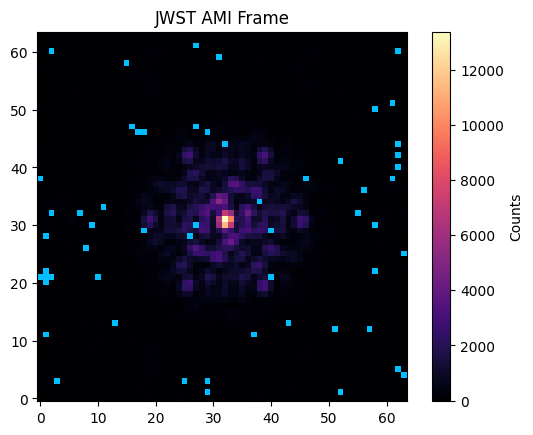

In [23]:
cmap = plt.get_cmap('magma')
cmap.set_bad(color='deepskyblue')

plt.imshow(data_nan, cmap=cmap)
plt.title('JWST AMI Frame')
plt.colorbar(label='Counts')
plt.show()

# Optimisation

In [24]:
flux_path = 'PointSource.flux'
coeffs_path = 'optics.Pupil.coefficients'

parameter_paths = [flux_path, coeffs_path]

In [25]:
# model instrument
model = instrument

# So first we simply set the simple parameters to use an adam optimiser 
# algorithm, with individual learning rates
flux_optimiser  = optax.adam(1e5, b1=0.85)
coeff_optimiser = optax.adam(2e-8)

# Combine the optimisers into a list
optimisers = [flux_optimiser, coeff_optimiser]

# Generate out optax optimiser, and also get our args
optim, opt_state = zdx.get_optimiser(model, parameter_paths, optimisers)

In [43]:
# Can't use poisson because of negative values
@zdx.filter_jit
@zdx.filter_value_and_grad(parameter_paths)
def loss_fn(model, data):
    out = np.where(bad_mask, 0, model.model())  # Set bad pixels to 0
    # return -np.sum(jax.scipy.stats.poisson.logpmf(data, out))
    return np.sum(np.log10(np.abs(data - out)))

In [44]:
%%time
loss, grads = loss_fn(model, data) # Compile
print("Initial Loss: {}".format(int(loss)))

OverflowError: cannot convert float infinity to integer

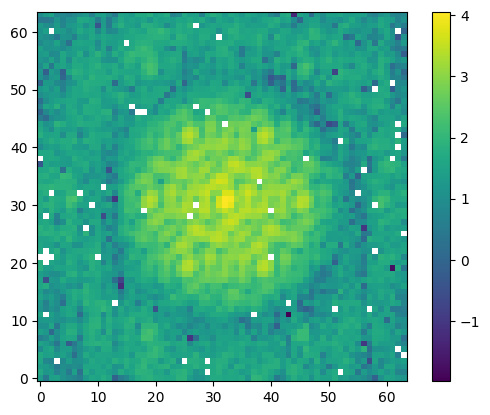

In [46]:
out = np.array(np.where(bad_mask, 0, model.model()))
plt.imshow(np.log10(np.abs(data - out)))
plt.colorbar()
plt.show()


In [43]:
out = model.model()[~bad_pixel_mask]
type(out)

jaxlib.xla_extension.ArrayImpl

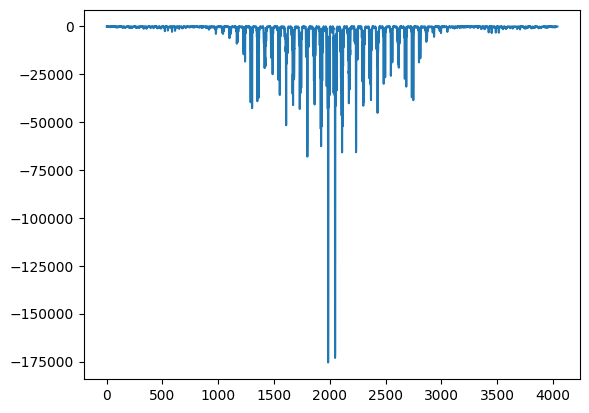

In [45]:
plt.plot(jax.scipy.stats.poisson.logpmf(data, out))